In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [293]:
import matplotlib.pyplot as plt
import os
import random
import shutil


In [294]:
def image_paths(image_name,image_folder_path):
    image_path = []
    for i in image_name:
        image_path.append(os.path.join(image_folder_path,i))
    return image_path


In [295]:
image_name_cartoon = os.listdir('/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/0')
image_folder_path_cartoon = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/0'
image_path_cartoon= image_paths(image_name_cartoon,image_folder_path_cartoon)

In [296]:
def plot_sample(image_path):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    img_sample = random.sample(image_path, 5)
    for n,(ax,img) in enumerate(zip(axs, img_sample)):
        ax.imshow(plt.imread(img))
        ax.set_title(f'Sample Image Number {n+1}')
        ax.axis('off')
    plt.show()


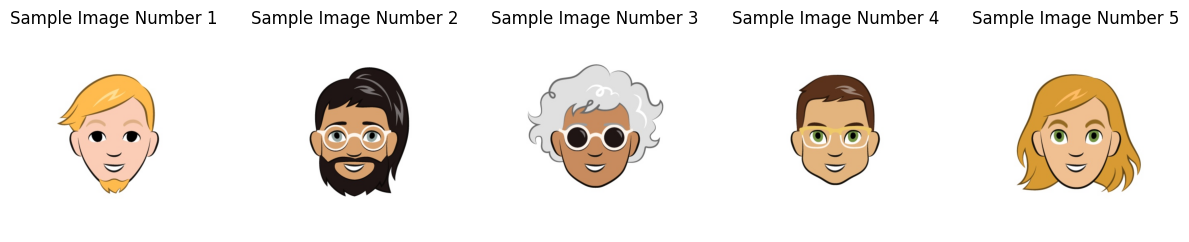

In [297]:
plot_sample(image_path_cartoon)

In [298]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [299]:
class VAE(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VAE, self).__init__()

        self.conv0 = nn.Conv2d(3, 64, 7, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 128, 5, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 3)
        self.conv3 = nn.Conv2d(256, 1024, 3)

        self.im2hid = nn.Linear(input_dim, h_dim)
        self.hid2mu = nn.Linear(h_dim, z_dim)
        self.hid2sigma = nn.Linear(h_dim, z_dim)

        self.z2hid = nn.Linear(z_dim, h_dim)
        self.hid2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()
        self.DO = nn.Dropout(0.5,inplace=False)
        self.sigmoid = nn.Sigmoid()

        self.Tconv0 = nn.ConvTranspose2d(1024, 256, 3)
        self.Tconv1 = nn.ConvTranspose2d(256, 128, 3)
        self.Tconv2 = nn.ConvTranspose2d(128, 64, 3)
        self.Tconv3 = nn.ConvTranspose2d(64, 16, 5)
        self.Tconv4 = nn.ConvTranspose2d(16, 3, 5)

    def encode(self, x):
        x = self.relu(self.bn0(self.conv0(x)))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.DO(x)
        h = self.relu(self.im2hid(x))
        mu, sigma = self.hid2mu(h), self.hid2sigma(h)
        return mu, sigma

    def decode(self, z):
        x = self.relu(self.z2hid(z))
        x = self.hid2img(x)
        x = x.view(x.size(0),1024,26,26)
        x = self.relu(self.Tconv0(x))
        x = self.relu(self.Tconv1(x))
        x = self.relu(self.Tconv2(x))
        x = self.relu(self.Tconv3(x))
        x = self.sigmoid(self.Tconv4(x))
        return x

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z = mu + torch.log(1 + torch.exp(sigma))* epsilon
        x_recon = self.decode(z)
        return x_recon, mu, sigma


In [300]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(directory, filename) for directory in self.image_dir for filename in os.listdir(directory) if filename.endswith('.jpg')]
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = plt.imread(img_path)
        if self.transform:
            image = self.transform(image)

        return image


In [301]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((40, 40)),transforms.Normalize((0.5,), (0.5,))
])

image_folder_path_cartoon = ['/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/0','/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/1','/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/2','/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/3','/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg/4']
dataset_cartoon = CustomDataset(image_folder_path_cartoon, transform=transform)
dataloader_cartoon = DataLoader(dataset_cartoon, batch_size=80, shuffle=True)

In [ ]:
input_dim=692224

h_dim=400
z_dim=35

model_cartoon = VAE(input_dim,h_dim,z_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_model(model, dataloader, optimizer, criterion,device,num_epochs=10):
    train_losses_epoch = []
    train_losses_recon = []
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        recon_loss_v = 0.0

        for batch_number, images in enumerate(dataloader):
            images = images.to(device)
            output, mu, sigma = model(images)

            recon_loss = F.mse_loss(images, output,reduction='sum')
            kl_div = -0.5 * torch.sum(1 + torch.log(sigma.exp()) - mu.pow(2) - sigma.exp())
            loss = 1.5*recon_loss + 1*kl_div

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            recon_loss_v += recon_loss.item()

            if (batch_number + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_number+1}/{len(dataloader)}], Loss: {loss.item():.5f}")

        train_losses_epoch.append(epoch_loss / len(dataloader))
        train_losses_recon.append(recon_loss_v / len(dataloader))

        print('**********************')
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, Recon Loss: {recon_loss_v:.5f}")
        print('**********************')

    return train_losses_epoch, train_losses_recon


In [ ]:
optimizer = optim.Adam(model_cartoon.parameters(), lr=2e-6)
criterion = F.mse_loss
train_losses_epoch_cartoon, train_losses_recon_cartoon = train_model(model_cartoon, dataloader_cartoon,optimizer, criterion, device ,num_epochs = 5)

In [ ]:
train_losses_epoch_cartoon1, train_losses_recon_cartoon1 = train_model(model_cartoon, dataloader_cartoon,optimizer, criterion, device ,num_epochs = 5)

In [ ]:
torch.save(model_cartoon.state_dict(), 'model_scripted.pt')

In [302]:
def decoder_img(model,x,device):
    x = x.reshape(1,35).to(device)
    model.eval()
    img = model.decode(x)
    plt.imshow(img[0].permute(1,2,0).cpu().detach().numpy())


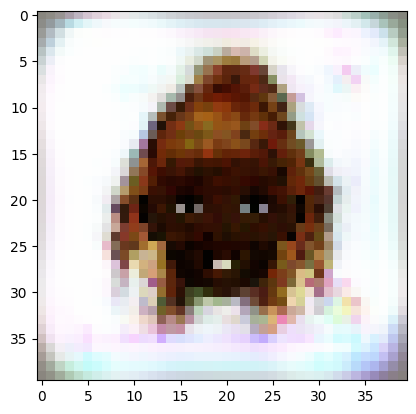

In [303]:
for i in dataloader_cartoon:
    a,b = model_cartoon.encode(torch.unsqueeze(i[43],0).to(device))
    break


z = torch.rand(35).to(device)*-1.9+ torch.exp(1*b[0]/2)

decoder_img(model_cartoon,z,device)

In [327]:
def plot(num_epochs,train_losses_epoch,train_losses_recon):
    
    plt.figure(figsize=(7, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_epoch, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('\n')
    plt.figure(figsize=(7, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_recon, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Reconstruction Loss')
    plt.legend()
    plt.show()


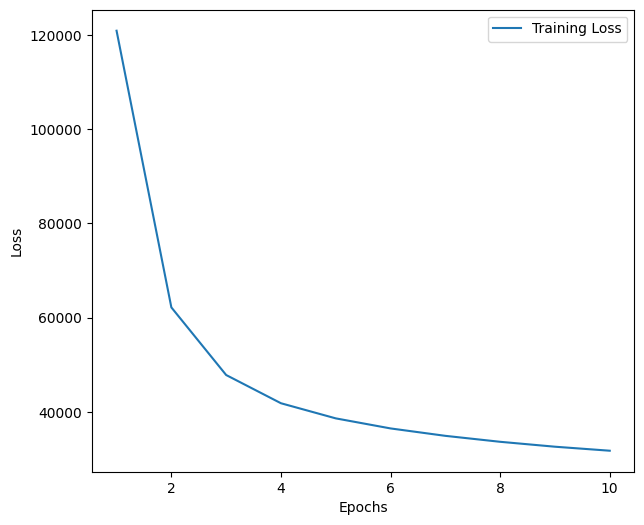

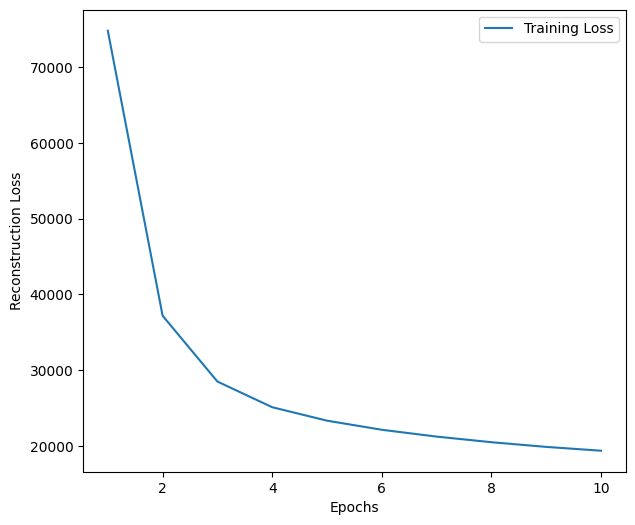

In [328]:
plot(10,np.concatenate((train_losses_epoch_cartoon,train_losses_epoch_cartoon1)),np.concatenate((train_losses_recon_cartoon,train_losses_recon_cartoon1)))

In [343]:
def decoder_imgs(model, device, num_images=100, fig_size=(15, 15)):
    rows = cols = int(num_images ** 0.5)  
    fig, axs = plt.subplots(rows, cols, figsize=fig_size)  

    for i in range(num_images):
        z = torch.rand(35).to(device) * torch.randint(-4, 0, (1,)).to(device) + torch.exp(torch.randint(-2, 2, (1,)).to(device) * torch.rand(35).to(device) / 2)
        z = z.reshape(1, 35).to(device)
        img = model.decode(z)
        ax = axs[i // cols, i % cols]
        ax.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
        ax.axis('off')

    plt.show()


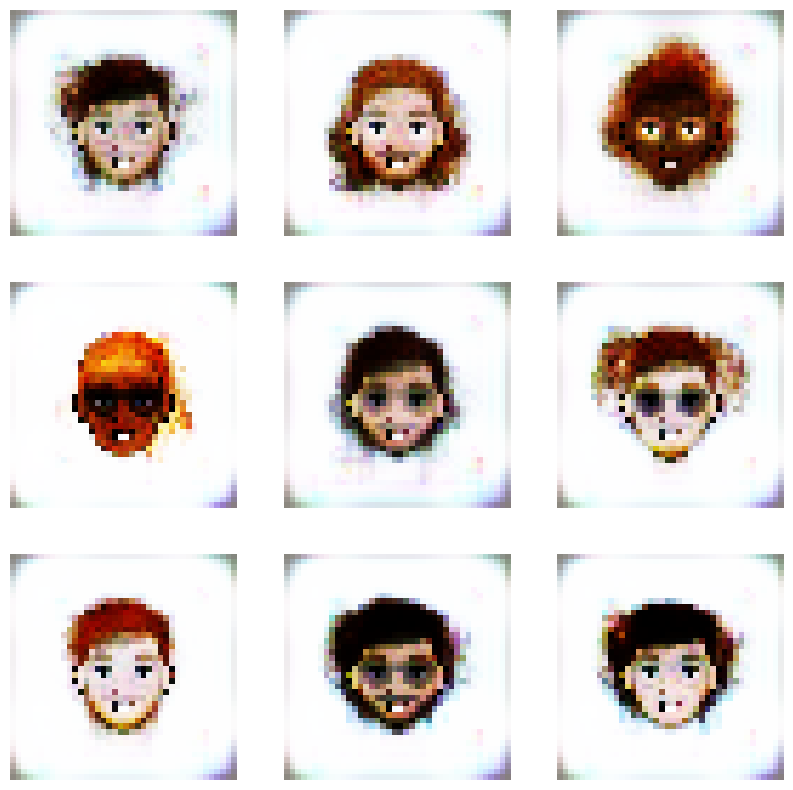

In [338]:
decoder_imgs(model_cartoon, device, num_images=9, fig_size=(10, 10))


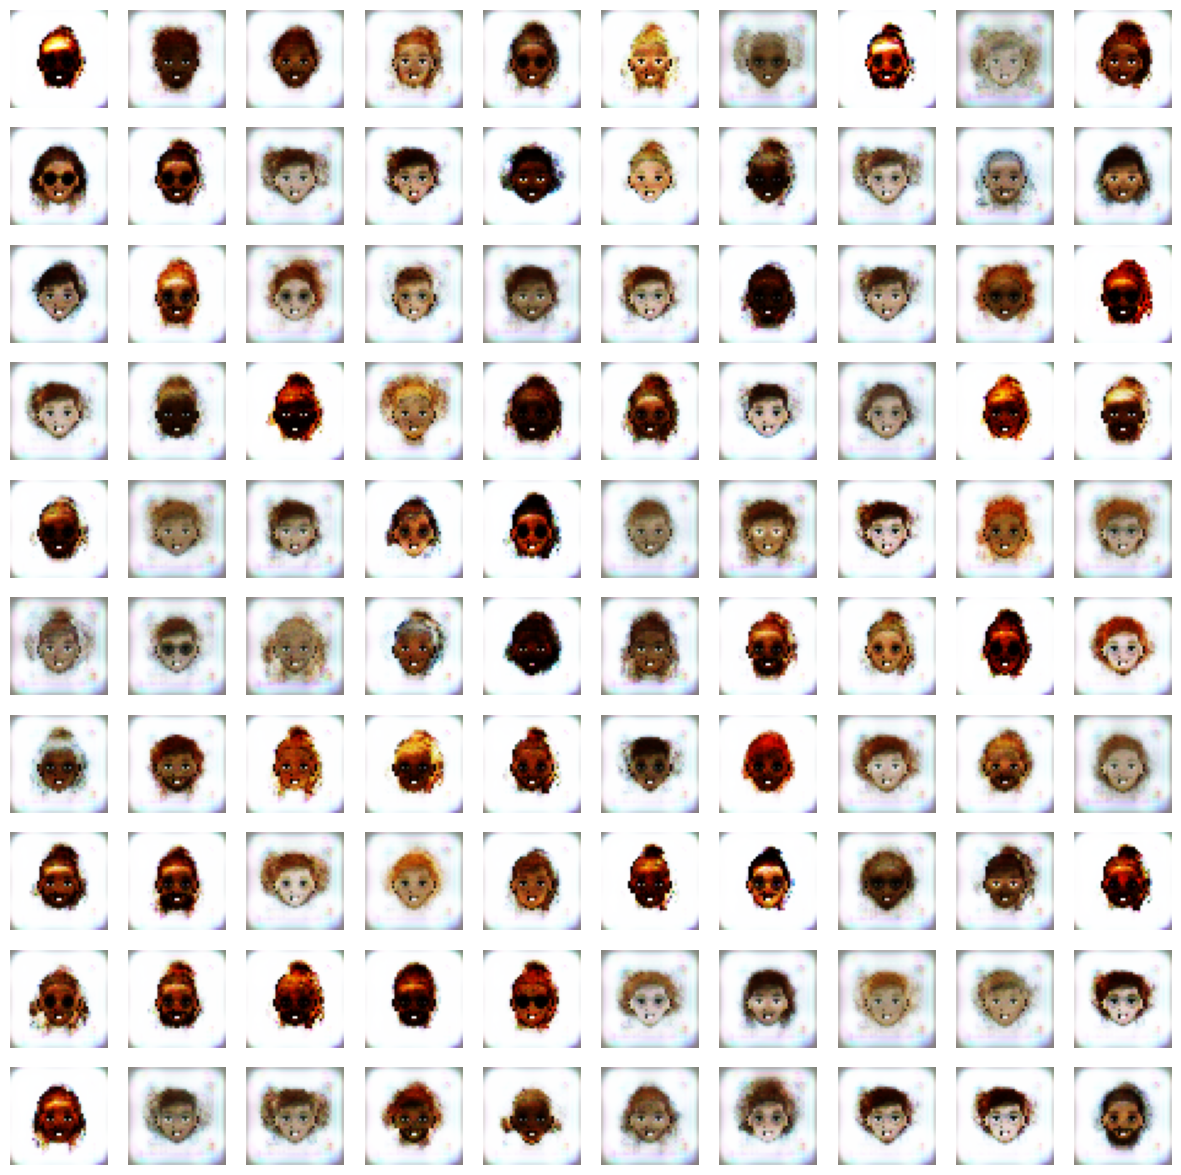

In [344]:
decoder_imgs(model_cartoon, device, num_images=100, fig_size=(15, 15))


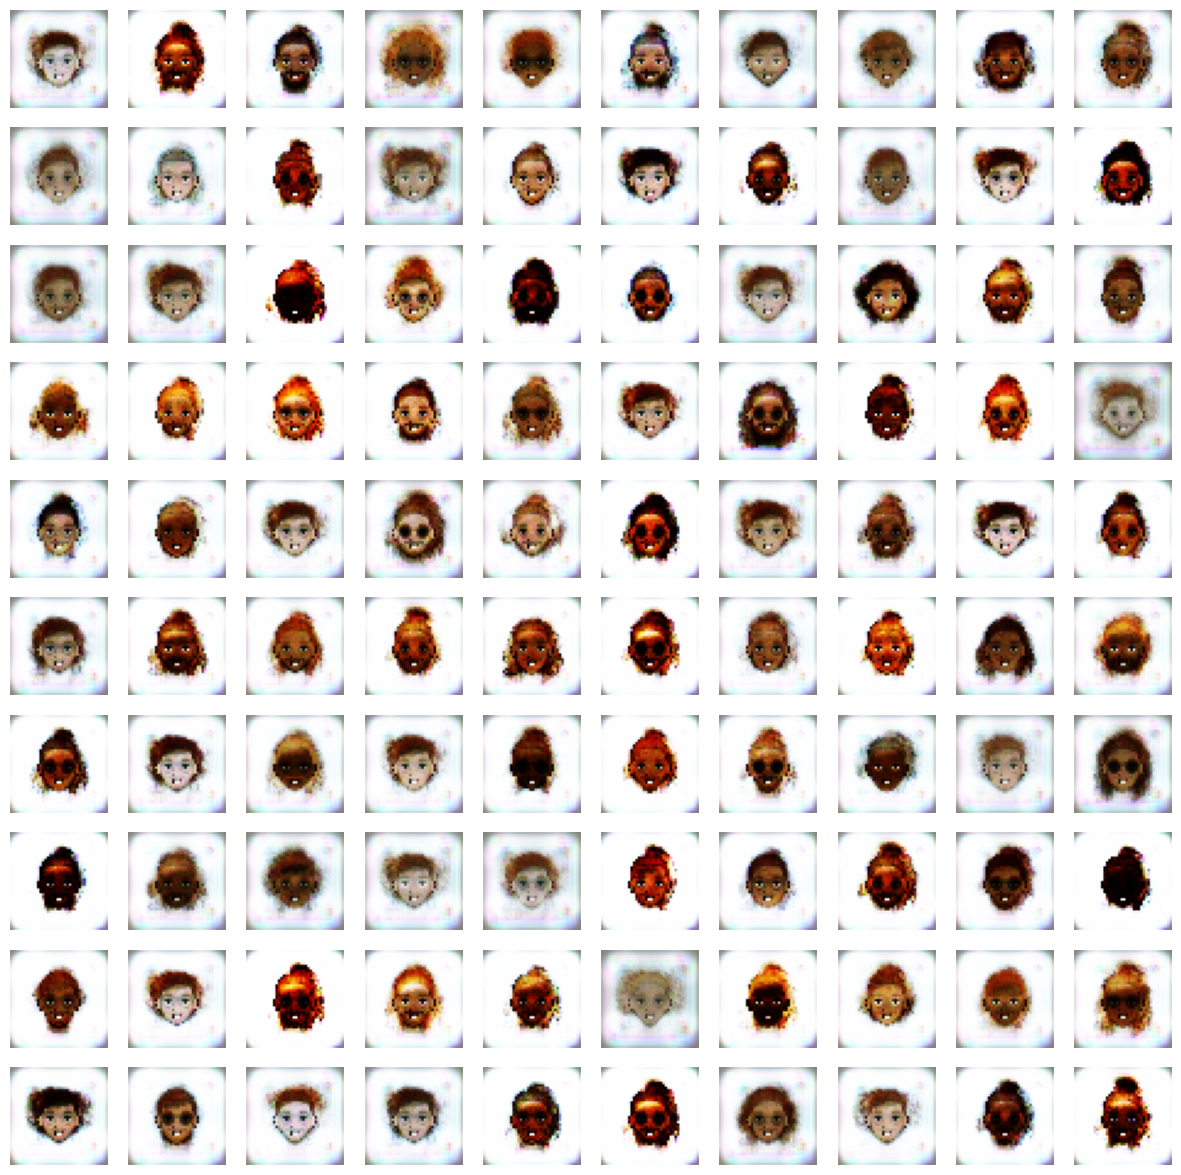

In [345]:
decoder_imgs(model_cartoon, device, num_images=100, fig_size=(15, 15))
